# 1_data_prep_Barbie
streamlined notebook showing the current routine of grid loading and trimming before we save in the form used for training and testing pitchforks

- duplicated for different grids
- upstream of sandbox files used to test new data augmentations and make plots - do not mess around with grids here!

In [1]:
#misc
import pandas as pd
import numpy as np
import h5py
import random
import time
import os

#plotting
import matplotlib.pyplot as plt
from cmcrameri import cm

## load in the grid:
 - Check headers against BASTA docs here: https://basta.readthedocs.io/en/latest/controls_parameters.html

In [2]:
barbie_h5 = h5py.File("/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/Garstec_AS09_barbieMS.hdf5", 'r')

print(list(barbie_h5['grid/tracks/track0001']))

['BP_GAIA', 'FeH', 'FeHini', 'G_GAIA', 'LPhot', 'MMaxNucE', 'Mbcz', 'Mcore', 'McoreX', 'MeH', 'MeHini', 'PS', 'RMaxNucE', 'RP_GAIA', 'Rbcz', 'Rcore', 'RcoreX', 'TAMS', 'Teff', 'ZAMSLPhot', 'ZAMSTeff', 'age', 'alphaFe', 'alphaMLT', 'd02fit', 'd02mean', 'dage', 'dif', 'dnuAsf', 'dnuSer', 'dnufit', 'dnufitMos12', 'dnuscal', 'epsfit', 'epsfitMos12', 'errflagSer', 'eta', 'fdnuAsf', 'fdnuSer', 'gcut', 'logg', 'massfin', 'massini', 'modnum', 'name', 'numax', 'numaxAsf', 'nummodSer', 'osc', 'osckey', 'ove', 'radPhot', 'radTot', 'rho', 'rhocen', 'tau0', 'taubcz', 'tauhe', 'volume_weight', 'xcen', 'xini', 'xsur', 'ycen', 'yini', 'ysur', 'zcen', 'zini', 'zsur']


135


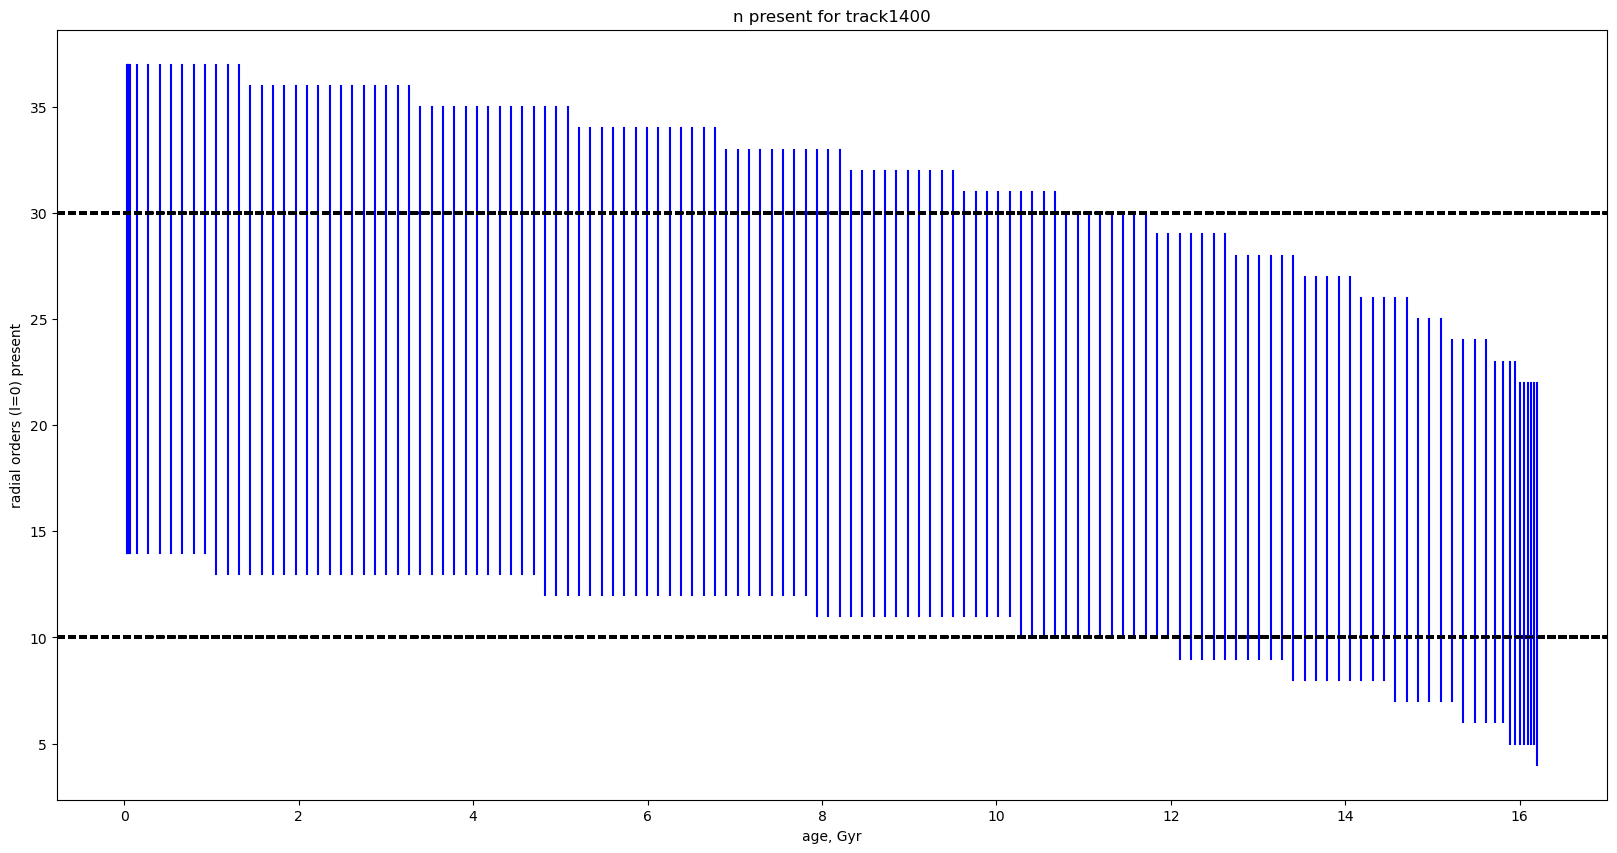

In [3]:
def n_present_plot(grid, track_id, max_age=np.inf):
    plt.figure(figsize=(20,10))
    
    points = np.array(grid['grid/tracks/track'+track_id+'/age'])[np.where(np.array(grid['grid/tracks/track'+track_id+'/age'])<=max_age)[0]]
    first_point = points[0]
    last_point = points[-1]
    
    i = 0
    for point in points:
        osckeys = grid['grid/tracks/track'+track_id+'/osckey']
        n_upper = osckeys[i][1][np.where(osckeys[i][0] == 0)[0][-1]]
        n_lower = osckeys[i][1][np.where(osckeys[i][0] == 0)[0][0]]

        plt.plot(np.full(2,point)/1000, np.array([n_upper, n_lower]), color='blue')

        plt.axhline(10, linestyle='dashed', color='black')
        plt.axhline(30, linestyle='dashed', color='black')
        # if point == first_point:
        #     plt.axhline(n_lower, linestyle='dashed', color='black')
        # elif point == last_point:
        #     plt.axhline(n_upper, linestyle='dashed', color='black')
        i+=1

    plt.xlabel('age, Gyr')
    plt.ylabel('radial orders (l=0) present')
    plt.title('n present for track'+track_id)
    print(i)
    
n_present_plot(barbie_h5, '1400')
#print(barbie_h5['grid/tracks/track0001/osckey'][0][1][np.where(barbie_h5['grid/tracks/track0001/osckey'][0][0] == 0)])
#print(barbie_h5['grid/tracks/track0001/osc'][0][0][np.where(barbie_h5['grid/tracks/track0001/osckey'][0][0] == 0)])

/tmp/ipykernel_1296289/4154876449.py:27: RuntimeWarning: invalid value encountered in scalar divide
  nu_upper_pad = np.arange(nu_max+dnufit, nu_max+(dnufit*(n_diff+1)), dnufit)


490


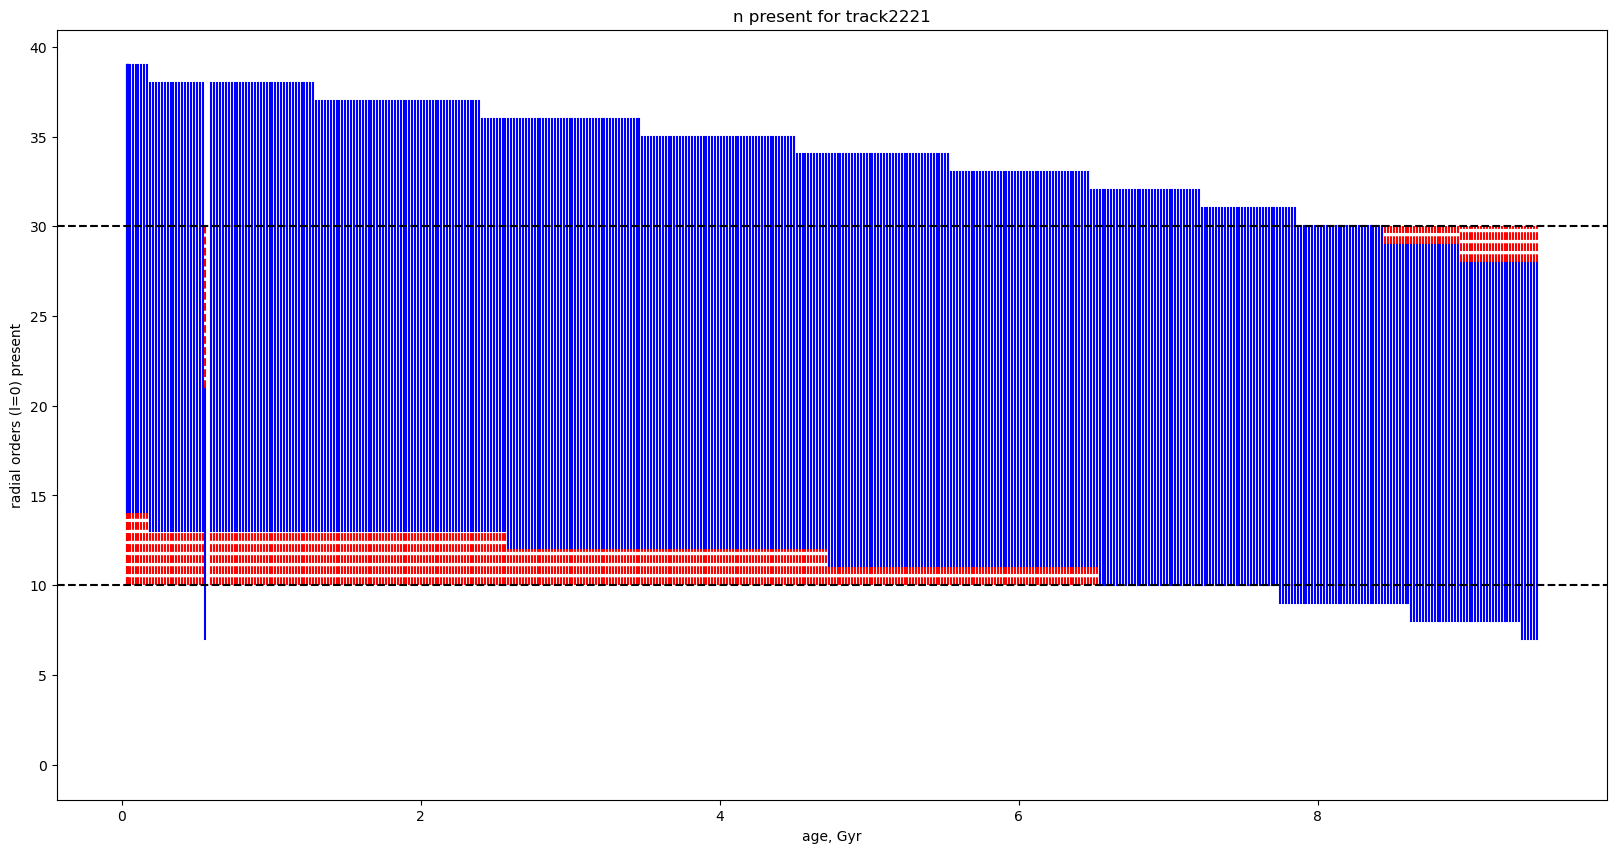

In [11]:
def n_padded_plot(grid, track_id, n_min=15, n_max=25, max_age=np.inf):
    plt.figure(figsize=(20,10))

    track = grid['grid/tracks/track'+track_id]
    age = track['age']

    points = np.array(age)[np.where(np.array(age)<=max_age)[0]]
    first_point = points[0]
    last_point = points[-1]
    
    osckeys = track['osckey']
    dnufits = track['dnufit']
    
    i = 0
    for point in points:
        n_vals = osckeys[i][1][np.where(osckeys[i][0] == 0)[0]]
        n_upper = n_vals[-1]
        n_lower = n_vals[0]
        
        nu_vals = list(track['osc'][i][0][np.where(osckeys[i][0] == 0)])
        plt.plot(np.full(2,point)/1000, np.array([n_upper, n_lower]), color='blue')
        if n_upper < n_max:
            dnufit = dnufits[i]
            nu_max = nu_vals[-1]
            n_diff = n_max - n_upper
            try:
                nu_upper_pad = np.arange(nu_max+dnufit, nu_max+(dnufit*(n_diff+1)), dnufit)
            except:
                nu_upper_pad = np.full(n_diff, nu_max)
                n_upper=n_max
            nu_vals = nu_vals + nu_upper_pad.tolist()
            plt.plot(np.full(2,point)/1000, np.array([n_upper, n_max]), color='red', linestyle='dashed')
        
        if n_lower > n_min:
            dnufit = dnufits[i]
            nu_min = nu_vals[0]
            n_diff = n_lower - n_min
            try:
                nu_lower_pad = np.arange(nu_min-(n_diff*dnufit), nu_min, dnufit)
            except:
                nu_lower_pad = np.full(n_diff, nu_min)
                n_lower=n_min
            nu_vals = nu_lower_pad.tolist() + nu_vals
            plt.plot(np.full(2,point)/1000, np.array([n_min, n_lower]), color='red', linestyle='dashed')
 
        i+=1
        
    plt.axhline(n_min, linestyle='dashed', color='black')
    plt.axhline(n_max, linestyle='dashed', color='black')

    plt.xlabel('age, Gyr')
    plt.ylabel('radial orders (l=0) present')
    plt.title('n present for track'+track_id)
    print(i)
    
n_padded_plot(barbie_h5, '2221', 10, 30)
#print(barbie_h5['grid/tracks/track0001/osckey'][0][1][np.where(barbie_h5['grid/tracks/track0001/osckey'][0][0] == 0)])
#print(barbie_h5['grid/tracks/track0001/osc'][0][0][np.where(barbie_h5['grid/tracks/track0001/osckey'][0][0] == 0)])

/tmp/ipykernel_1296215/3917296295.py:28: RuntimeWarning: invalid value encountered in scalar divide
  nu_upper_pad = np.arange(nu_max+dnufit, nu_max+(dnufit*(n_diff+1)), dnufit)


490


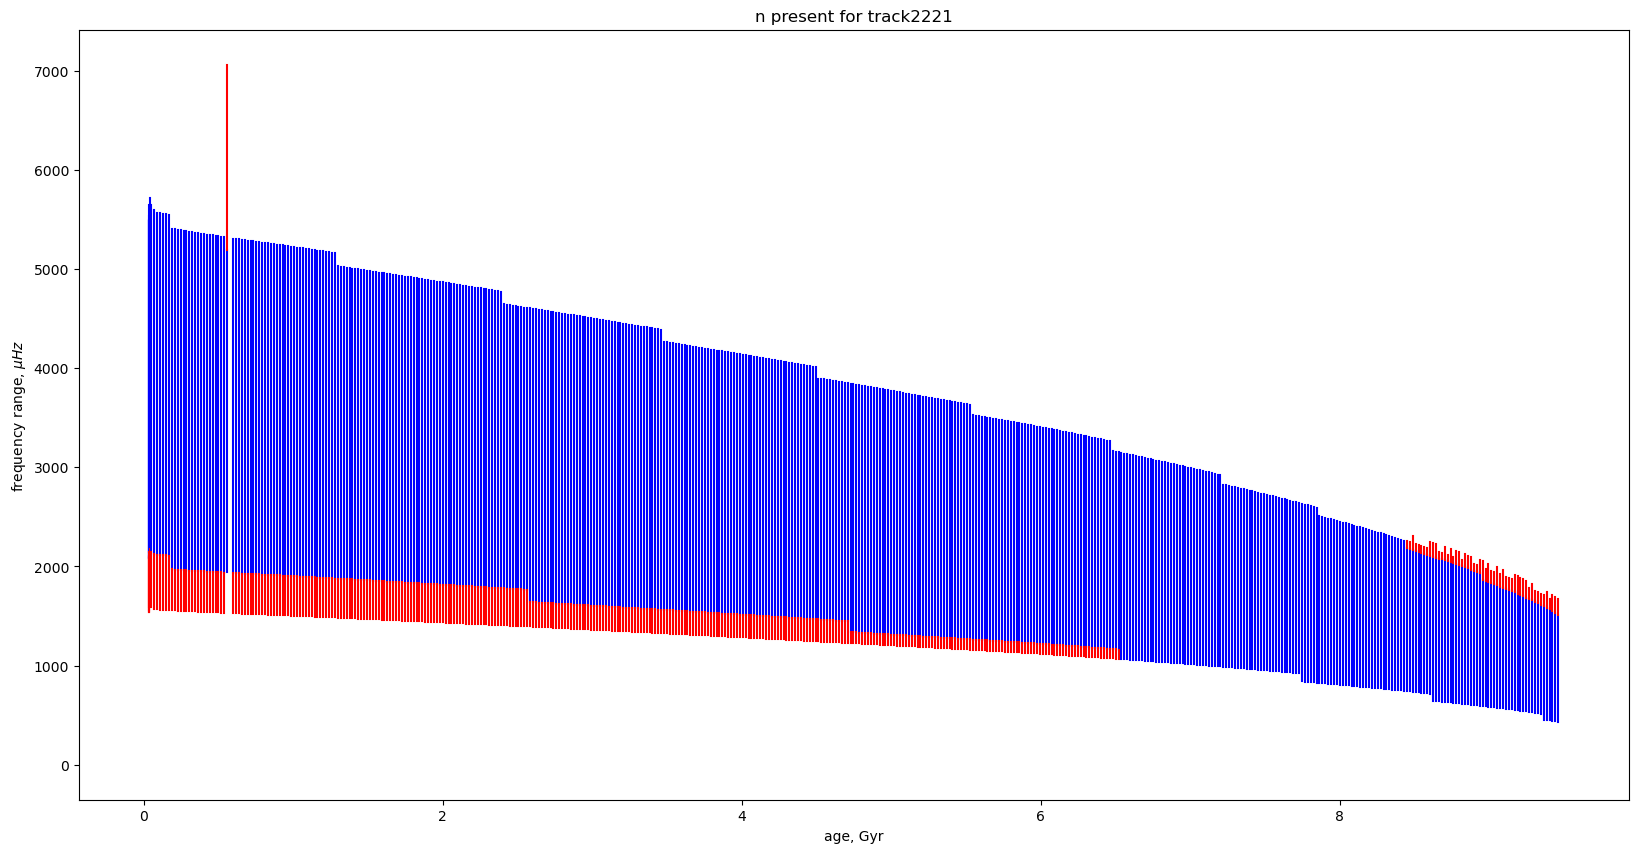

In [6]:
def n_padded_plot(grid, track_id, n_min=15, n_max=25, max_age=np.inf):
    plt.figure(figsize=(20,10))

    track = grid['grid/tracks/track'+track_id]
    age = track['age']

    points = np.array(age)[np.where(np.array(age)<=max_age)[0]]
    first_point = points[0]
    last_point = points[-1]
    
    osckeys = track['osckey']
    dnufits = track['dnufit']
    
    i = 0
    for point in points:
        n_vals = osckeys[i][1][np.where(osckeys[i][0] == 0)[0]]
        n_upper = n_vals[-1]
        n_lower = n_vals[0]
        
        nu_vals = list(track['osc'][i][0][np.where(osckeys[i][0] == 0)])
        plt.plot(np.full(2,point)/1000, np.array([nu_vals[0], nu_vals[-1]]), color='blue')

        if n_upper < n_max:
            dnufit = dnufits[i]
            nu_max = nu_vals[-1]
            n_diff = n_max - n_upper
            try:
                nu_upper_pad = np.arange(nu_max+dnufit, nu_max+(dnufit*(n_diff+1)), dnufit)
            except:
                nu_upper_pad = np.zeros(0)
            nu_vals = nu_vals + nu_upper_pad.tolist()
            plt.plot(np.full(2,point)/1000, np.array([nu_max, nu_vals[-1]]), color='red')
        
        if n_lower > n_min:
            dnufit = dnufits[i]
            nu_min = nu_vals[0]
            n_diff = n_lower - n_min
            try:
                nu_lower_pad = np.arange(nu_min-(n_diff*dnufit), nu_min, dnufit)
            except:
                nu_upper_pad = np.zeros(0)
            nu_vals = nu_lower_pad.tolist() + nu_vals
            plt.plot(np.full(2,point)/1000, np.array([nu_vals[0], nu_min]), color='red')

        i+=1


    plt.xlabel('age, Gyr')
    plt.ylabel('frequency range, $\mu Hz$')
    plt.title('n present for track'+track_id)
    print(i)
    
n_padded_plot(barbie_h5, '2221', 10, 30)
#print(barbie_h5['grid/tracks/track0001/osckey'][0][1][np.where(barbie_h5['grid/tracks/track0001/osckey'][0][0] == 0)])
#print(barbie_h5['grid/tracks/track0001/osc'][0][0][np.where(barbie_h5['grid/tracks/track0001/osckey'][0][0] == 0)])

/tmp/ipykernel_1296289/1062225511.py:28: RuntimeWarning: invalid value encountered in scalar divide
  nu_upper_pad = np.arange(nu_max+dnufit, nu_max+(dnufit*(n_diff+1)), dnufit)


490


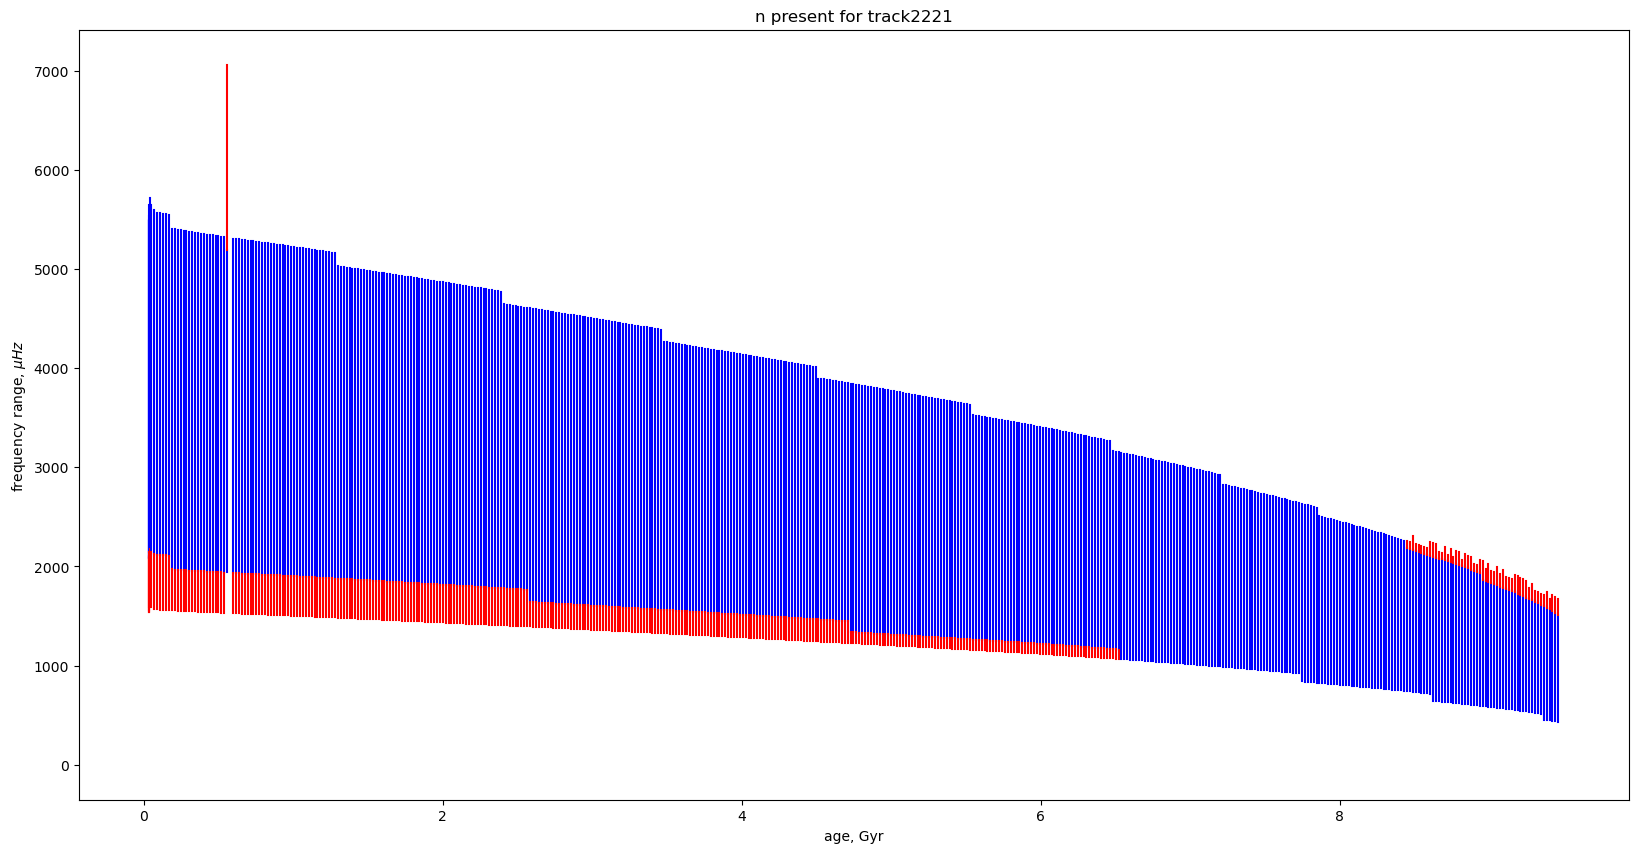

In [12]:
def n_padded_plot(grid, track_id, n_min=15, n_max=25, max_age=np.inf):
    plt.figure(figsize=(20,10))

    track = grid['grid/tracks/track'+track_id]
    age = track['age']

    points = np.array(age)[np.where(np.array(age)<=max_age)[0]]
    first_point = points[0]
    last_point = points[-1]
    
    osckeys = track['osckey']
    dnufits = track['dnufit']
    
    i = 0
    for point in points:
        n_vals = osckeys[i][1][np.where(osckeys[i][0] == 0)[0]]
        n_upper = n_vals[-1]
        n_lower = n_vals[0]
        
        nu_vals = list(track['osc'][i][0][np.where(osckeys[i][0] == 0)])
        plt.plot(np.full(2,point)/1000, np.array([nu_vals[0], nu_vals[-1]]), color='blue')

        if n_upper < n_max:
            dnufit = dnufits[i]
            nu_max = nu_vals[-1]
            n_diff = n_max - n_upper
            try:
                nu_upper_pad = np.arange(nu_max+dnufit, nu_max+(dnufit*(n_diff+1)), dnufit)
            except:
                nu_upper_pad = np.zeros(0)
            nu_vals = nu_vals + nu_upper_pad.tolist()
            plt.plot(np.full(2,point)/1000, np.array([nu_max, nu_vals[-1]]), color='red')
        
        if n_lower > n_min:
            dnufit = dnufits[i]
            nu_min = nu_vals[0]
            n_diff = n_lower - n_min
            try:
                nu_lower_pad = np.arange(nu_min-(n_diff*dnufit), nu_min, dnufit)
            except:
                nu_lower_pad = np.zeros(0)
            nu_vals = nu_lower_pad.tolist() + nu_vals
            plt.plot(np.full(2,point)/1000, np.array([nu_vals[0], nu_min]), color='red')

        i+=1


    plt.xlabel('age, Gyr')
    plt.ylabel('frequency range, $\mu Hz$')
    plt.title('n present for track'+track_id)
    print(i)
    
n_padded_plot(barbie_h5, '2221', 10, 30)
#print(barbie_h5['grid/tracks/track0001/osckey'][0][1][np.where(barbie_h5['grid/tracks/track0001/osckey'][0][0] == 0)])
#print(barbie_h5['grid/tracks/track0001/osc'][0][0][np.where(barbie_h5['grid/tracks/track0001/osckey'][0][0] == 0)])

In [29]:
nu_upper_pad

NameError: name 'nu_upper_pad' is not defined

In [18]:
print(barbie_h5['grid/tracks/track0001/osc'][0][0][np.where(barbie_h5['grid/tracks/track0001/osckey'][0][0] == 0)])

[2417.2099 2584.767  2752.6303 2920.2396 3086.6793 3251.9148 3417.6238
 3583.9896 3751.4953 3919.1915 4087.0665 4255.0233 4423.2184 4591.9709
 4760.9512 4930.3779 5099.8507 5269.6267 5439.4253 5609.338  5779.2116
 5948.8801 6118.2024 6286.4557]


In [22]:
np.arange(1,5)

array([1, 2, 3, 4])

In [23]:
barbie_h5['grid/tracks/track0001/osckey'][0]

array([array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
              1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
              2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
              3, 3, 3, 3, 3, 3, 3, 3, 3, 3])                                   ,
       array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
              30, 31, 32, 33, 34, 35, 36, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
              22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 12, 13,
              14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
              31, 32, 33, 34, 35, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
              23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])               ],
      dtype=object)